# Extraction of Audio Features

- Version 1.2
- Liam Kelly
- Sep 8th, 2022

## Introduction


### Methodology

## 1. Import Packages and Visualize Data Sample

Before we start creating features from our audio data, let's inspect the shape of a sample audio file.

In [2]:
# Import packages:
import os
import numpy as np
import pandas as pd
import librosa
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

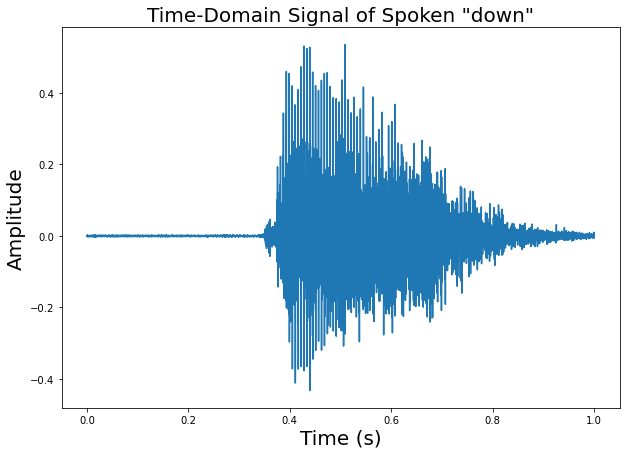

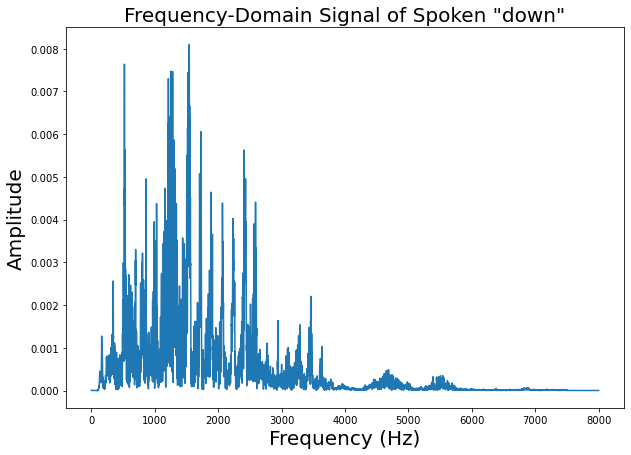

In [3]:
# Inputs:
folder = 'data_mini/'
sub_folder_i = 0
item_i = 1

# Load the data
path = folder + os.listdir(folder)[sub_folder_i]+ '/' # Select the folder of the sample audio file.
data, s_rate = librosa.load(path + os.listdir(path)[item_i], sr =16000)
t = np.arange(len(data))/s_rate # Create time array.

# Plot the time domain signal:
plt.figure(figsize = (10,7))
plt.plot(t, data)
plt.xlabel('Time (s)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title('Time-Domain Signal of Spoken "%s"' % path[len(folder):-1], fontsize = 20)
plt.show()

# Calculate the Fourier transform of the time domain signal using the FFT.
n_t =len(data) 
data_fft = 2/n_t * (abs(fft(data))) # Calculate the abosulte value of the frequency components.
f = fftfreq(n_t, 1/s_rate) # Calculate the frequency steps.

plt.figure(figsize = (10,7))
plt.plot(f[:n_t//2], data_fft[:n_t//2])
plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title('Frequency-Domain Signal of Spoken "%s"' % path[len(folder):-1], fontsize = 20)
plt.show()

## 2. Extract Features From Audio Data

### 2.1 Description of Audio Features
Features can be created from an audio sample by measuring characterisitics of the signal in both the time and frequency domain. Audio characteristics with their meanings and equations are listed below:

##### The Normalized Magnitude Spectrum
The following functions will be written in terms of the normalized magnitude spectrum, which takes the absolute value of all data points normalizes all data to the fraction of its contribution to the total signal.

$$ \hat{x}(i) = \frac{|x(i)|}{\sum_{i=1}^{N}{|x(i)|}} $$

#### 2.1.1 Signal Centroid
The centroid of a signal describes the balancing point of the sound event energy.

$$ C_{i} = \sum_{i=1}^{N}{i\hat{x}(i)} $$

#### 2.1.2 Signal Bandwidth
The signal badnwidth describes the width of the signal by averaging the weighted absolute distances from the centroid. 

$$ S_{f} = \sqrt{\sum_{i=1}^{N}{(i - C_{f})^{2}\hat{x}(i)}} $$

#### 2.1.3 Signal Skewdness
The signal skewdness describes the asymmetry of the signal's distribution about the signal's centroid.

$$ 	\gamma_{1} = \frac{\sum_{i=1}^{N}{(i - C_{f})^{3}\hat{x}(i)}}{S_{f}^{3}} $$

#### 2.1.4 Signal Kurtosis
The signal kurtosis describes the peakiness of the signal.

$$ 	\gamma_{2} = \frac{\sum_{i=1}^{N}{(i - C_{f})^{4}\hat{x}(i)}}{S_{f}^{4}} $$

#### 2.1.5 Signal Flatness
The signal flatness describes how flat (or white-noisy) an audio signal is.

$$ 	SFM = 10log_{10}\left[\frac{\sqrt[N]{\prod_{i=1}^{N}{\hat{x}(i)}}}{\frac{1}{N}\sum_{i=1}^{N}{\hat{x}(i)}}\right] $$

#### 2.1.6 Signal Irregularity
The signal irregularity desctribes the jaggedness of the signal.

$$ SI = \frac{\sum_{i=1}^{N-1}{(\hat{x}(i) - \hat{x}(i+1))^{2}}}{\sum_{k=1}^{N}{\hat{x}(i)}} $$

#### 2.1.7 Signal Roll-Off
The signal roll-off defines the index R below which 95% of the energy resides.

$$ \sum_{k=1}^{R}{\hat{X}(k)^{2}} \geq 0.95\sum_{k=1}^{N}{\hat{X}(k)^{2}}  $$


##### Ommission of Features for Classification Models
Each of the above characterisitcs can be evaluated on frequency and time domain signals. However, a few characterisitcs will be ommited due to their incompatilibity with the classification task at hand.

The temporal centroid will be omitted as it is a description of where the audio signal is located along the time axis. If a test sampe is recorded in a manner that the audio signal is shifted along the time axis, the classification model may incorrectly factor this feature into classification. Since the temporal centroid should have no relation to the spoken word, it should be omitted from the model.

Furthermore, the temporal flatness will be omitted. Due to the prescence of 0-valued terms in the time domain signal, the geometric sum in the numerator evalues to -inf when the geometric sum is computed using a log function.  Thus most values are -inf and are not suitable for use in a classification algorithm.

### 2.2 Audio Feature Extraction Algorithm

The audio features will now be calculated for each audio file in the dataset. The result from each audio file will be stored as a row in a dataframe, which is then saved as a csv file upon completion.

In [10]:
# Inputs
folder = 'data_mini/'
csv_name = 'audio_df.csv'


# Initialize DataFrame to hold audio features:
df = pd.DataFrame()

# Perform for loop over each file to calculate features and store in the dataframe (df)
j = 1
i = 0 # Initialize row index
for subfolder in os.listdir(folder):
    path = folder + subfolder + '/'
    print('Currently loading the \033[1m%s\033[0m subfolder... (%i/%i)        ' % (subfolder, j, len(os.listdir(folder))), end = '\r')
    j += 1
    for item in os.listdir(path):
        # Load the data
        x, s_rate = librosa.load(path + item, sr = 16000)
        
        # Create array to ramp up the time domain signal from 0 to better represent a pulsed signal.
        mult = np.ones(len(x))
        mult[:1001] = np.linspace(0,1,1001)
        mult[-1001:] = np.linspace(1,0,1001)
        
        x = x*mult
        t = np.arange(len(x))/s_rate
        df.loc[ i , ['id', 'word','data_len','sampling_rate'] ] = [item[:-4], subfolder, len(x), s_rate]
        x_hat = abs(x)/np.sum(abs(x))
        
        ### Calculate Time-Domain Features ###
        
        # 1. Calculate the temporal bandwidth:
        temp_cent = np.sum(t*x_hat) # Temporal centroid
        temp_bw = np.sqrt(np.sum(((t - temp_cent)**2)*x_hat))
        df.loc[i, 'temporal_bandwidth'] = temp_bw
        
        # 2. Calculate the temporal skwedness
        temp_skew = np.sum(((t-temp_cent)**3)*x_hat)/(temp_bw**3)
        df.loc[i, 'temporal_skewness'] = temp_skew
        
        # 3. Calculate the temporal kurtosis:
        temp_kurt = np.sum(((t-temp_cent)**4)*x_hat)/(temp_bw**4)
        df.loc[i, 'temporal_kurtosis'] = temp_kurt
        
        # 4. Calculate the temporal irregularity:
        x_i = x_hat[:-1]
        x_i1 = x_hat[1:]
        temp_irreg = np.mean((x_i - x_i1)**2)/np.mean(x_hat**2)
        df.loc[i, 'temporal_irregularity'] =  temp_irreg
        
        
        ### Calculate Frequency Domain Features ###
        # Perform Fourier Transform (X), calculate frequency data (f) and normalized magnitude spectrum(X_hat)
        n_t = len(x) 
        X = 2/n_t*(abs(fft(x)))[:n_t//2]
        f = fftfreq(n_t, 1/s_rate)[:n_t//2]
        X_hat = abs(X)/np.sum(abs(X))
        
        # Connvert frequency to mel-scale:
        f_mel = 2595*np.log10(f/700 + 1)
        
        # 1. Calculate the spectral centroid:
        spec_cent = np.sum(f_mel*X_hat)
        df.loc[i, 'spectral_centroid'] = spec_cent
    
        # 2. Calculate the bandwidth of the spectrum:
        # Measures the weighted difference between spectral components and the spectral centroid.
        spec_bw = np.sqrt(np.sum(((f_mel - spec_cent)**2)*X_hat))
        df.loc[i, 'spectral_bandwidth'] = spec_bw
        
        # 3. Calculate the spectral skewdness:
        # Measures how the spectrum is skewed about the spectral centroid.
        spec_skew = np.sum(((f_mel-spec_cent)**3)*X_hat)/(spec_bw**3)
        df.loc[i, 'spectral_skewness'] = spec_skew
        
        # 4. Calculate the spectral kurtosis:
        # Measure of the peakiness of the spectrum
        spec_kurt = np.sum(((f_mel-spec_cent)**4)*X_hat)/(spec_bw**4)
        df.loc[i, 'spectral_kurtosis'] = spec_kurt
        
        # 5. Calculate the spectral flatness:
        # Is a measure of how 'white-noisy' as signal is. A Low value indicates a noisy signal, while a high value is indicative of tonal sounds 
        spec_flat = 10*np.log10(np.exp(np.log(X_hat).mean())/X_hat.mean())
        df.loc[i, 'spectral_flatness'] = spec_flat
        
        # 6. Calculate the spectral irregularity:
        X_i = X_hat[:-1]
        X_i1 = X_hat[1:]
        spec_irreg = np.mean((X_i - X_i1)**2)/np.mean(X_hat**2)
        df.loc[i, 'spectral_irregularity'] =  spec_irreg
        
        # 7. Calculate the spectral roll-off:
        tot_energy = np.sum(X_hat**2)
        indices = np.where(np.cumsum(X_hat**2) > 0.95*tot_energy)
        df.loc[i, 'spectral_rolloff'] = min(f_mel[indices])
        i+=1
        
print('Done!                                                  ', end = '\r')      

# Save the dataframe to a csv file:
df.to_csv(csv_name, index = False)        

In [12]:
# Display the head of the dataframe and print its shape:
display(df.drop(columns = ['data_len','sampling_rate']).head())
print(df.shape)

,id,word,temporal_bandwidth,temporal_skewness,temporal_kurtosis,temporal_irregularity,spectral_centroid,spectral_bandwidth,spectral_skewness,spectral_kurtosis,spectral_flatness,spectral_irregularity,spectral_rolloff
0,004ae714_nohash_0,down,0.138942,-0.883279,6.286660,0.641607,1812.621718,410.098678,-1.642777,6.356789,-6.847276,0.075192,2133.526166
1,00b01445_nohash_1,down,0.130594,0.301250,2.955263,0.274938,1334.102695,461.832080,0.139646,2.963423,-8.171098,0.072307,1736.532500
2,00f0204f_nohash_0,down,0.212064,0.691076,2.468556,0.085359,1024.409352,590.452277,0.588880,2.546914,-7.479742,0.087896,1567.566041
3,0132a06d_nohash_1,down,0.112829,0.752850,2.835493,0.058967,873.151317,506.134604,0.927812,3.699689,-10.433229,0.030764,1222.457943
4,0132a06d_nohash_4,down,0.118419,1.071481,3.284768,0.059089,919.714212,492.781386,0.786826,3.273135,-11.055224,0.031067,1042.911451


(8000, 15)
